# Apprentissage par Renforcement en Deep Learning : De Q-Learning à Deep RL

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer l'**Apprentissage par Renforcement** (Reinforcement Learning) :

1. **Q-Learning classique** - L'approche traditionnelle avec tables
2. **Deep Q-Network (DQN)** - La révolution du Deep RL
3. **Experience Replay & Target Network** - Les mécanismes clés
4. **Applications pratiques** - Agent intelligent en action

Nous utiliserons l'environnement **CartPole** de OpenAI Gym pour entraîner nos agents à équilibrer un bâton.

## Pourquoi le Deep Reinforcement Learning ?

Le Deep RL a révolutionné l'IA en 2013-2015 (DeepMind avec Atari) :
- Capacité à gérer des espaces d'états continus et haute dimension
- Apprentissage de stratégies complexes sans supervision
- Base d'AlphaGo, AlphaZero, et agents de jeux vidéo super-humains
- Applications en robotique, finance, conduite autonome

## 📚 Concepts clés que nous allons explorer

- **MDP (Markov Decision Process)** : Formalisation mathématique du problème
- **Q-Learning** : Apprendre la valeur des actions dans chaque état
- **Experience Replay** : Réutiliser les expériences passées
- **Target Network** : Stabiliser l'apprentissage
- **Epsilon-Greedy** : Équilibrer exploration vs exploitation
- **Policy vs Value-based** : Deux paradigmes complémentaires

## 1. Imports et Configuration

In [1]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
from collections import deque, defaultdict
import random
import time

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import Callback

# Gym pour les environnements RL
try:
    import gymnasium as gym
    print("✅ Gymnasium détecté (nouvelle version)")
except ImportError:
    import gym
    print("✅ OpenAI Gym détecté (ancienne version)")

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")
print(f"📦 Gym version: {gym.__version__}")

2025-11-05 22:18:31.330157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Gymnasium détecté (nouvelle version)
✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.20.0
📦 Keras version: 3.12.0
📦 Gym version: 1.2.2


## 2. Comprendre l'Environnement : GridWorld Simple

Avant de plonger dans des environnements complexes, commençons par un **GridWorld** simple.
C'est un environnement pédagogique où un agent doit naviguer dans une grille pour atteindre un objectif.

### 🎮 Description de l'environnement
- **Grille 5x5** avec un agent, un objectif, et des obstacles
- **Actions** : Haut, Bas, Gauche, Droite
- **Récompenses** : +10 pour atteindre l'objectif, -1 pour chaque mouvement, -5 pour obstacle
- **Objectif** : Apprendre le chemin optimal vers le but

In [2]:
class GridWorld:
    """Environnement GridWorld simple pour l'apprentissage par renforcement"""
    
    def __init__(self, size=5):
        self.size = size
        self.action_space = 4  # Haut, Bas, Gauche, Droite
        self.state_space = size * size
        
        # Positions
        self.agent_pos = [0, 0]  # Position initiale
        self.goal_pos = [size-1, size-1]  # Objectif en bas à droite
        self.obstacles = [[1, 1], [2, 2], [3, 1]]  # Obstacles
        
        # Actions: 0=Haut, 1=Bas, 2=Gauche, 3=Droite
        self.actions = {0: [-1, 0], 1: [1, 0], 2: [0, -1], 3: [0, 1]}
        self.action_names = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    
    def reset(self):
        """Réinitialiser l'environnement"""
        self.agent_pos = [0, 0]
        return self._get_state()
    
    def _get_state(self):
        """Convertir position en numéro d'état"""
        return self.agent_pos[0] * self.size + self.agent_pos[1]
    
    def step(self, action):
        """Exécuter une action et retourner (nouvel_état, récompense, terminé)"""
        # Calculer nouvelle position
        new_pos = [
            self.agent_pos[0] + self.actions[action][0],
            self.agent_pos[1] + self.actions[action][1]
        ]
        
        # Vérifier les limites
        if (new_pos[0] < 0 or new_pos[0] >= self.size or 
            new_pos[1] < 0 or new_pos[1] >= self.size):
            return self._get_state(), -1, False  # Reste sur place, pénalité
        
        # Vérifier obstacles
        if new_pos in self.obstacles:
            return self._get_state(), -5, False  # Grosse pénalité
        
        # Mettre à jour position
        self.agent_pos = new_pos
        
        # Vérifier si objectif atteint
        if self.agent_pos == self.goal_pos:
            return self._get_state(), 10, True  # Récompense + terminé
        
        return self._get_state(), -1, False  # Coût de déplacement
    
    def render(self, q_table=None):
        """Afficher l'environnement"""
        grid = np.zeros((self.size, self.size), dtype=str)
        grid[:] = '·'
        
        # Marquer obstacles
        for obs in self.obstacles:
            grid[obs[0], obs[1]] = '█'
        
        # Marquer objectif
        grid[self.goal_pos[0], self.goal_pos[1]] = '🎯'
        
        # Marquer agent
        grid[self.agent_pos[0], self.agent_pos[1]] = '🤖'
        
        print("\nGridWorld:")
        for row in grid:
            print(' '.join(row))
        
        # Afficher Q-values si disponibles
        if q_table is not None:
            print("\nMeilleure action par état:")
            policy_grid = np.zeros((self.size, self.size), dtype=str)
            for i in range(self.size):
                for j in range(self.size):
                    state = i * self.size + j
                    if [i, j] == self.goal_pos:
                        policy_grid[i, j] = '🎯'
                    elif [i, j] in self.obstacles:
                        policy_grid[i, j] = '█'
                    else:
                        best_action = np.argmax(q_table[state])
                        policy_grid[i, j] = self.action_names[best_action]
            
            for row in policy_grid:
                print(' '.join(row))

# Créer et tester l'environnement
env = GridWorld(size=5)
state = env.reset()
env.render()
print(f"\n✅ État initial: {state}")
print(f"✅ Espace d'états: {env.state_space}")
print(f"✅ Espace d'actions: {env.action_space}")


GridWorld:
🤖 · · · ·
· █ · · ·
· · █ · ·
· █ · · ·
· · · · 🎯

✅ État initial: 0
✅ Espace d'états: 25
✅ Espace d'actions: 4


## 3. Q-Learning Classique : L'Approche Traditionnelle

### 🧠 Théorie du Q-Learning

Le **Q-Learning** est un algorithme d'apprentissage par renforcement qui apprend la **fonction Q** :

$$Q(s, a) = \text{Valeur de prendre l'action } a \text{ dans l'état } s$$

#### Équation de mise à jour de Bellman :

$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

Où :
- $\alpha$ = learning rate (taux d'apprentissage)
- $r$ = récompense immédiate
- $\gamma$ = discount factor (facteur de discount)
- $s'$ = état suivant
- $\max_{a'} Q(s', a')$ = meilleure valeur Q pour l'état suivant

#### Stratégie Epsilon-Greedy :
- Avec probabilité $\epsilon$ : **exploration** (action aléatoire)
- Avec probabilité $1-\epsilon$ : **exploitation** (meilleure action connue)

### 📊 Avantages et Limites

✅ **Avantages :**
- Simple à comprendre et implémenter
- Garanti de converger vers l'optimal (sous certaines conditions)
- Pas besoin de modèle de l'environnement

❌ **Limites :**
- Ne fonctionne que pour des **espaces d'états discrets et petits**
- Table Q de taille $|S| \times |A|$ devient immense
- Impossible pour états continus (ex: images, positions continues)

In [3]:
class QLearningAgent:
    """Agent Q-Learning classique avec table Q"""
    
    def __init__(self, state_space, action_space, learning_rate=0.1, 
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Table Q : état x action
        self.q_table = np.zeros((state_space, action_space))
    
    def choose_action(self, state):
        """Choisir action avec stratégie epsilon-greedy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_space)  # Exploration
        return np.argmax(self.q_table[state])  # Exploitation
    
    def learn(self, state, action, reward, next_state, done):
        """Mettre à jour Q-table avec l'équation de Bellman"""
        # Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
        current_q = self.q_table[state, action]
        
        if done:
            # Si terminal, pas de valeur future
            target_q = reward
        else:
            # Valeur future = meilleure Q-value du prochain état
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.gamma * max_next_q
        
        # Mise à jour
        self.q_table[state, action] += self.lr * (target_q - current_q)
    
    def decay_epsilon(self):
        """Décrémenter epsilon pour réduire exploration"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✅ Classe QLearningAgent définie")

✅ Classe QLearningAgent définie


### 🎯 Entraînement de l'Agent Q-Learning

In [4]:
def train_q_learning(env, agent, episodes=500, max_steps=50, verbose=True):
    """Entraîner l'agent Q-Learning"""
    rewards_history = []
    epsilon_history = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Choisir et exécuter action
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            
            # Apprendre
            agent.learn(state, action, reward, next_state, done)
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        # Décrémenter epsilon
        agent.decay_epsilon()
        
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        
        if verbose and (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode+1}/{episodes} - "
                  f"Récompense moyenne: {avg_reward:.2f} - "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return rewards_history, epsilon_history

# Créer et entraîner agent
print("🚀 Début de l'entraînement Q-Learning...\n")
env = GridWorld(size=5)
agent_qlearning = QLearningAgent(
    state_space=env.state_space,
    action_space=env.action_space,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.995
)

rewards_ql, epsilon_ql = train_q_learning(env, agent_qlearning, episodes=500)
print("\n✅ Entraînement terminé!")

🚀 Début de l'entraînement Q-Learning...

Episode 100/500 - Récompense moyenne: -38.26 - Epsilon: 0.606
Episode 200/500 - Récompense moyenne: -8.24 - Epsilon: 0.367
Episode 300/500 - Récompense moyenne: -1.69 - Epsilon: 0.222
Episode 400/500 - Récompense moyenne: -0.06 - Epsilon: 0.135
Episode 500/500 - Récompense moyenne: 1.44 - Epsilon: 0.082

✅ Entraînement terminé!


### 📊 Visualisation des Résultats Q-Learning

/tmp/ipykernel_3099/1295709284.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1295709284.py:47: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1295709284.py:47: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1295709284.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zeus/miniconda3/envs/cloudspace/lib

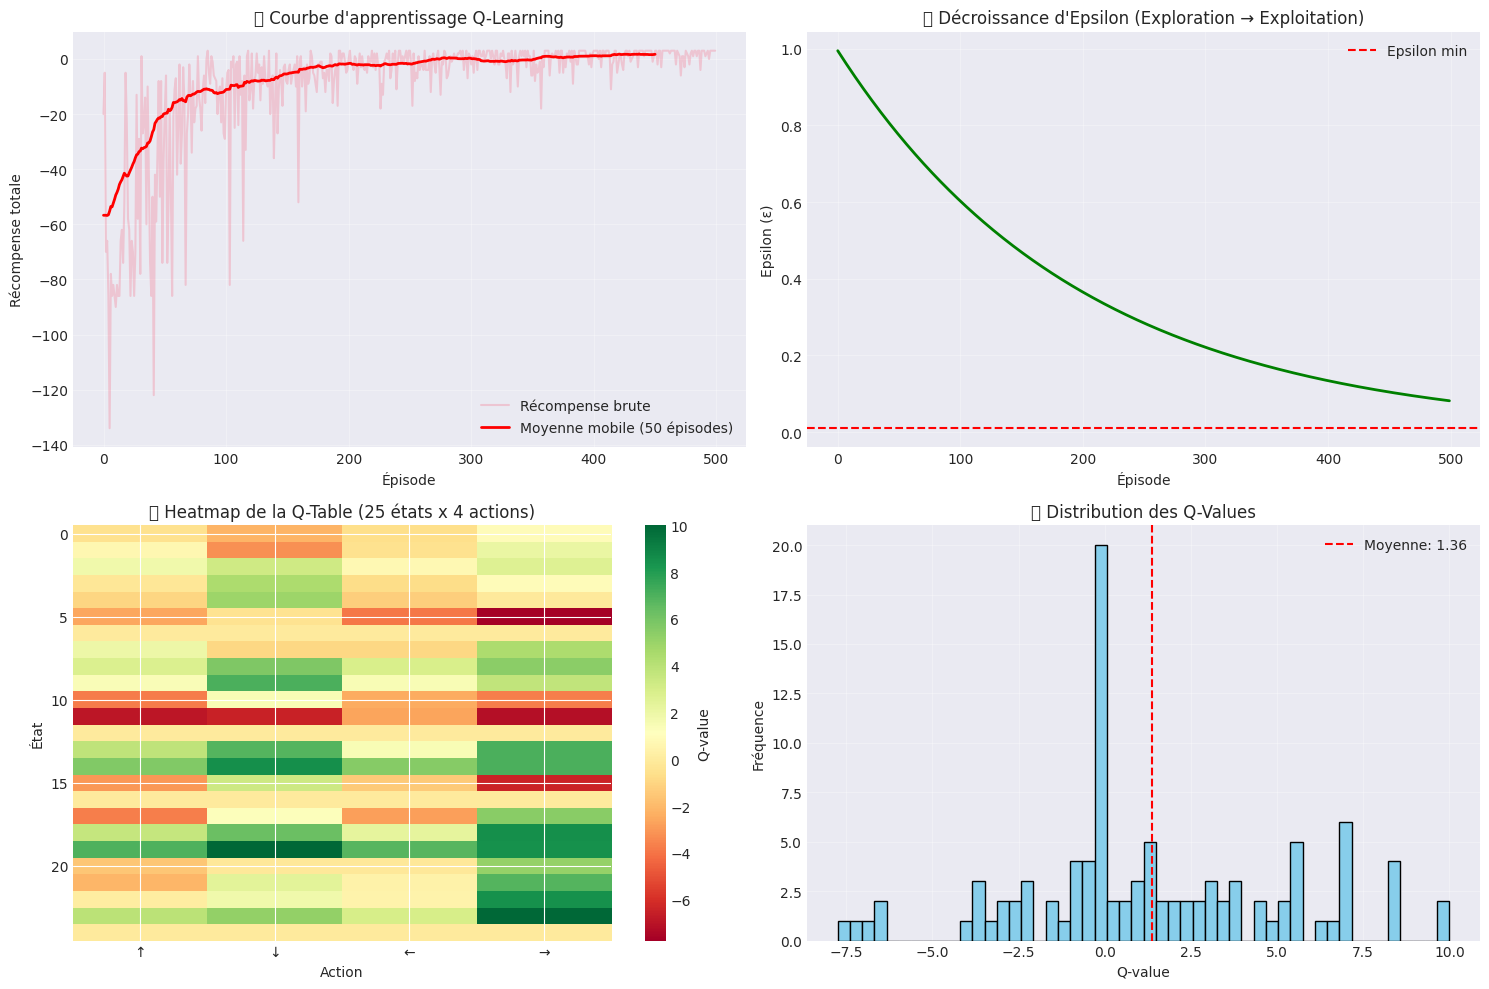


📊 Statistiques finales:
  - Récompense moyenne (100 derniers): 1.44
  - Q-value max: 10.00
  - Q-value min: -7.75
  - Epsilon final: 0.0816


In [5]:
# Fonction pour calculer moyenne mobile
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Récompenses par épisode
axes[0, 0].plot(rewards_ql, alpha=0.3, label='Récompense brute')
axes[0, 0].plot(moving_average(rewards_ql, 50), linewidth=2, 
                label='Moyenne mobile (50 épisodes)', color='red')
axes[0, 0].set_xlabel('Épisode')
axes[0, 0].set_ylabel('Récompense totale')
axes[0, 0].set_title('📈 Courbe d\'apprentissage Q-Learning')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Décroissance d'Epsilon
axes[0, 1].plot(epsilon_ql, color='green', linewidth=2)
axes[0, 1].set_xlabel('Épisode')
axes[0, 1].set_ylabel('Epsilon (ε)')
axes[0, 1].set_title('🎯 Décroissance d\'Epsilon (Exploration → Exploitation)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.01, color='red', linestyle='--', label='Epsilon min')
axes[0, 1].legend()

# 3. Heatmap de la Q-table (état x action)
im = axes[1, 0].imshow(agent_qlearning.q_table, cmap='RdYlGn', aspect='auto')
axes[1, 0].set_xlabel('Action')
axes[1, 0].set_ylabel('État')
axes[1, 0].set_title('🔥 Heatmap de la Q-Table (25 états x 4 actions)')
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(['↑', '↓', '←', '→'])
plt.colorbar(im, ax=axes[1, 0], label='Q-value')

# 4. Distribution des Q-values
q_values_flat = agent_qlearning.q_table.flatten()
axes[1, 1].hist(q_values_flat, bins=50, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Q-value')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('📊 Distribution des Q-Values')
axes[1, 1].axvline(x=q_values_flat.mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {q_values_flat.mean():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Statistiques finales:")
print(f"  - Récompense moyenne (100 derniers): {np.mean(rewards_ql[-100:]):.2f}")
print(f"  - Q-value max: {agent_qlearning.q_table.max():.2f}")
print(f"  - Q-value min: {agent_qlearning.q_table.min():.2f}")
print(f"  - Epsilon final: {agent_qlearning.epsilon:.4f}")

### 🎮 Visualiser la Politique Apprise

In [6]:
# Afficher la grille avec la politique apprise
env.reset()
env.render(q_table=agent_qlearning.q_table)

# Tester l'agent entraîné
print("\n🤖 Test de l'agent entraîné (mode exploitation pure):")
state = env.reset()
total_reward = 0
steps = 0

for step in range(50):
    action = np.argmax(agent_qlearning.q_table[state])  # Meilleure action
    next_state, reward, done = env.step(action)
    total_reward += reward
    steps += 1
    state = next_state
    
    if done:
        print(f"✅ Objectif atteint en {steps} étapes!")
        print(f"✅ Récompense totale: {total_reward}")
        break

if not done:
    print(f"❌ Objectif non atteint après {steps} étapes")


GridWorld:
🤖 · · · ·
· █ · · ·
· · █ · ·
· █ · · ·
· · · · 🎯

Meilleure action par état:
→ → ↓ ↓ ↓
↓ █ → ↓ ↓
↓ ← █ → ↓
↓ █ → → ↓
→ → → → 🎯

🤖 Test de l'agent entraîné (mode exploitation pure):
✅ Objectif atteint en 8 étapes!
✅ Récompense totale: 3


## 4. Limites du Q-Learning : Le Problème de Dimension

### 🚨 Le Problème

Imaginons des environnements plus complexes :

#### Exemple 1 : Image 84x84 en niveaux de gris
- **États possibles** : $256^{84 \times 84} \approx 10^{16000}$
- **Table Q nécessaire** : IMPOSSIBLE à stocker en mémoire

#### Exemple 2 : Jeu Atari Breakout
- **État** : Image 210x160x3 pixels
- **Actions** : 18 actions possibles
- **Table Q** : Astronomiquement grande

#### Exemple 3 : État continu (CartPole)
- **Position** : [-4.8, 4.8] (continu)
- **Vitesse** : [-∞, ∞] (continu)
- **Angle** : [-0.418, 0.418] rad (continu)
- **Vitesse angulaire** : [-∞, ∞] (continu)
- **Table Q** : Impossible de discrétiser finement

### 💡 La Solution : Deep Q-Networks (DQN)

Au lieu d'une **table Q**, utilisons un **réseau de neurones** pour approximer Q(s,a) :

$$Q(s, a; \theta) \approx Q^*(s, a)$$

Où $\theta$ sont les poids du réseau neuronal.

**Avantages :**
- ✅ Généralisation à des états non vus
- ✅ Gestion d'espaces d'états continus ou haute dimension
- ✅ Représentations apprises automatiquement
- ✅ Scalabilité

## 5. CartPole : Un Environnement avec État Continu

### 🎮 Description de CartPole

**CartPole-v1** est un problème classique de contrôle :
- Un chariot se déplace sur un rail horizontal
- Un bâton est attaché au chariot par un joint non actionné
- **Objectif** : Équilibrer le bâton en déplaçant le chariot (gauche/droite)

### 📊 Espace d'États (4 dimensions continues)

| Variable | Min | Max | Description |
|----------|-----|-----|-------------|
| Position du chariot | -4.8 | 4.8 | Position sur le rail |
| Vitesse du chariot | -∞ | ∞ | Vitesse de déplacement |
| Angle du bâton | -0.418 rad | 0.418 rad | Angle par rapport à la verticale |
| Vitesse angulaire | -∞ | ∞ | Vitesse de rotation |

### 🎯 Actions
- **0** : Pousser le chariot vers la gauche
- **1** : Pousser le chariot vers la droite

### 🏆 Récompenses
- **+1** pour chaque timestep où le bâton reste debout
- **Épisode termine** si : angle > 12° ou position > 2.4 ou 500 timesteps

In [7]:
# Créer l'environnement CartPole
try:
    import gymnasium as gym
    env_cartpole = gym.make('CartPole-v1')
except:
    import gym
    env_cartpole = gym.make('CartPole-v1')

print("🎮 Environnement CartPole-v1")
print(f"\n📊 Espace d'observations: {env_cartpole.observation_space}")
print(f"📊 Espace d'actions: {env_cartpole.action_space}")
print(f"📊 Dimension de l'état: {env_cartpole.observation_space.shape[0]}")
print(f"📊 Nombre d'actions: {env_cartpole.action_space.n}")

# Test de l'environnement
state = env_cartpole.reset()
if isinstance(state, tuple):  # Gymnasium retourne (state, info)
    state = state[0]
print(f"\n🎯 État initial: {state}")
print("   [position, vitesse, angle, vitesse_angulaire]")

# Épisode aléatoire pour visualiser
print("\n🎲 Épisode avec actions aléatoires:")
state = env_cartpole.reset()
if isinstance(state, tuple):
    state = state[0]
total_reward = 0

for step in range(100):
    action = env_cartpole.action_space.sample()  # Action aléatoire
    result = env_cartpole.step(action)
    
    if len(result) == 5:  # Gymnasium
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:  # Gym classique
        next_state, reward, done, info = result
    
    total_reward += reward
    state = next_state
    
    if done:
        print(f"   Épisode terminé après {step+1} timesteps")
        print(f"   Récompense totale: {total_reward}")
        break

print("\n💡 Observation: Un agent aléatoire ne tient pas longtemps!")
print("   Un agent entraîné devrait atteindre 500 timesteps (score max)")

🎮 Environnement CartPole-v1

📊 Espace d'observations: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
📊 Espace d'actions: Discrete(2)
📊 Dimension de l'état: 4
📊 Nombre d'actions: 2

🎯 État initial: [-0.00753599 -0.04856114 -0.01076439 -0.04138601]
   [position, vitesse, angle, vitesse_angulaire]

🎲 Épisode avec actions aléatoires:
   Épisode terminé après 26 timesteps
   Récompense totale: 26.0

💡 Observation: Un agent aléatoire ne tient pas longtemps!
   Un agent entraîné devrait atteindre 500 timesteps (score max)


## 6. Deep Q-Network (DQN) : La Révolution

### 🧠 Architecture DQN

DQN utilise un réseau de neurones pour approximer la fonction Q :

```
État (4 dim) → Dense(128) → ReLU → Dense(128) → ReLU → Dense(2) → Q-values
```

### 🔑 Innovations Clés de DQN (DeepMind 2015)

#### 1. **Experience Replay Buffer** 🔄
- Stocker les transitions $(s, a, r, s', done)$ dans un buffer
- Échantillonner aléatoirement des mini-batchs pour l'entraînement
- **Pourquoi ?**
  - Casse la corrélation temporelle des données
  - Réutilise efficacement les expériences
  - Stabilise l'apprentissage

#### 2. **Target Network** 🎯
- Deux réseaux : **Q-network** (mis à jour) et **Target network** (fixe temporairement)
- Le target network est copié du Q-network tous les N steps
- **Pourquoi ?**
  - Évite les oscillations dans l'apprentissage
  - Cibles plus stables pour la régression
  - Convergence plus rapide

### 📐 Équation de Loss

$$L(\theta) = \mathbb{E}_{(s,a,r,s') \sim D} \left[ \left( r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta) \right)^2 \right]$$

Où :
- $\theta$ = paramètres du Q-network
- $\theta^-$ = paramètres du target network (fixés)
- $D$ = replay buffer

### 🎯 Algorithme DQN

```
1. Initialiser Q-network et Target network
2. Initialiser replay buffer D
3. Pour chaque épisode:
   a. Observer état s
   b. Choisir action a (epsilon-greedy)
   c. Exécuter a, observer r, s'
   d. Stocker (s, a, r, s', done) dans D
   e. Échantillonner mini-batch de D
   f. Calculer target: y = r + γ max_a' Q_target(s', a')
   g. Mettre à jour Q-network: minimiser (y - Q(s,a))²
   h. Tous les C steps: copier Q-network → Target network
```

### 💾 Implémentation : Experience Replay Buffer

In [8]:
class ReplayBuffer:
    """Buffer pour stocker et échantillonner les expériences"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        """Ajouter une transition au buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Échantillonner un mini-batch aléatoire"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

print("✅ Classe ReplayBuffer définie")

✅ Classe ReplayBuffer définie


### 🧠 Implémentation : DQN Agent

In [9]:
class DQNAgent:
    """Agent Deep Q-Network avec Experience Replay et Target Network"""
    
    def __init__(self, state_size, action_size, learning_rate=0.001,
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.01, buffer_capacity=10000, batch_size=64,
                 target_update_freq=10):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0
        
        # Replay buffer
        self.memory = ReplayBuffer(capacity=buffer_capacity)
        
        # Q-Network et Target Network
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        """Construire le réseau de neurones Q-Network"""
        model = models.Sequential([
            layers.Dense(128, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.action_size, activation='linear')  # Q-values pour chaque action
        ])
        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.lr),
            loss='mse'
        )
        return model
    
    def update_target_model(self):
        """Copier les poids du Q-network vers le target network"""
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        """Stocker transition dans le replay buffer"""
        self.memory.add(state, action, reward, next_state, done)
    
    def choose_action(self, state):
        """Choisir action avec stratégie epsilon-greedy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)  # Exploration
        
        # Exploitation : prédire Q-values et choisir la meilleure action
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])
    
    def train(self):
        """Entraîner le réseau sur un mini-batch du replay buffer"""
        # Ne pas entraîner si pas assez d'expériences
        if len(self.memory) < self.batch_size:
            return 0
        
        # Échantillonner mini-batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Prédictions actuelles
        current_q_values = self.model.predict(states, verbose=0)
        
        # Cibles avec target network
        next_q_values = self.target_model.predict(next_states, verbose=0)
        
        # Calculer cibles
        targets = current_q_values.copy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                # Équation de Bellman avec target network
                targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        
        # Entraîner le modèle
        history = self.model.fit(states, targets, epochs=1, verbose=0)
        loss = history.history['loss'][0]
        
        # Mettre à jour target network périodiquement
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.update_target_model()
        
        return loss
    
    def decay_epsilon(self):
        """Décrémenter epsilon"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✅ Classe DQNAgent définie")

✅ Classe DQNAgent définie


### 🏋️ Entraînement du DQN Agent

In [10]:
def train_dqn(env, agent, episodes=500, max_steps=500, verbose=True):
    """Entraîner l'agent DQN"""
    rewards_history = []
    losses_history = []
    epsilon_history = []
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        episode_losses = []
        
        for step in range(max_steps):
            # Choisir et exécuter action
            action = agent.choose_action(state)
            result = env.step(action)
            
            if len(result) == 5:  # Gymnasium
                next_state, reward, terminated, truncated, info = result
                done = terminated or truncated
            else:  # Gym classique
                next_state, reward, done, info = result
            
            # Stocker dans replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Entraîner
            loss = agent.train()
            if loss > 0:
                episode_losses.append(loss)
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        # Décrémenter epsilon
        agent.decay_epsilon()
        
        rewards_history.append(total_reward)
        losses_history.append(np.mean(episode_losses) if episode_losses else 0)
        epsilon_history.append(agent.epsilon)
        
        if verbose and (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:])
            avg_loss = np.mean([l for l in losses_history[-50:] if l > 0])
            print(f"Episode {episode+1}/{episodes} - "
                  f"Récompense moyenne: {avg_reward:.2f} - "
                  f"Loss: {avg_loss:.4f} - "
                  f"Epsilon: {agent.epsilon:.3f} - "
                  f"Buffer: {len(agent.memory)}")
    
    return rewards_history, losses_history, epsilon_history

# Créer et entraîner DQN agent
print("🚀 Début de l'entraînement DQN...\n")
agent_dqn = DQNAgent(
    state_size=env_cartpole.observation_space.shape[0],
    action_size=env_cartpole.action_space.n,
    learning_rate=0.001,
    discount_factor=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    buffer_capacity=10000,
    batch_size=64,
    target_update_freq=10
)

rewards_dqn, losses_dqn, epsilon_dqn = train_dqn(
    env_cartpole, agent_dqn, episodes=500, max_steps=500
)

print("\n✅ Entraînement DQN terminé!")

🚀 Début de l'entraînement DQN...



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762381113.824711    3099 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1104 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9
2025-11-05 22:18:34.553095: I external/local_xla/xla/service/service.cc:163] XLA service 0x7eb6a4004c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 22:18:34.553118: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-11-05 22:18:34.559079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc

Episode 50/500 - Récompense moyenne: 26.90 - Loss: 13.3138 - Epsilon: 0.778 - Buffer: 1345
Episode 100/500 - Récompense moyenne: 55.26 - Loss: 301.3944 - Epsilon: 0.606 - Buffer: 4108
Episode 150/500 - Récompense moyenne: 83.58 - Loss: 648.0357 - Epsilon: 0.471 - Buffer: 8287
Episode 200/500 - Récompense moyenne: 55.56 - Loss: 285.3085 - Epsilon: 0.367 - Buffer: 10000
Episode 250/500 - Récompense moyenne: 63.34 - Loss: 279.5712 - Epsilon: 0.286 - Buffer: 10000
Episode 300/500 - Récompense moyenne: 102.14 - Loss: 172.1456 - Epsilon: 0.222 - Buffer: 10000
Episode 350/500 - Récompense moyenne: 193.38 - Loss: 121.8452 - Epsilon: 0.173 - Buffer: 10000
Episode 400/500 - Récompense moyenne: 184.56 - Loss: 137.5272 - Epsilon: 0.135 - Buffer: 10000
Episode 450/500 - Récompense moyenne: 260.64 - Loss: 34.2634 - Epsilon: 0.105 - Buffer: 10000
Episode 500/500 - Récompense moyenne: 269.38 - Loss: 39.3489 - Epsilon: 0.082 - Buffer: 10000

✅ Entraînement DQN terminé!


## 7. Visualisation et Comparaison des Résultats

### 📊 Analyse des Performances DQN

/tmp/ipykernel_3099/1515825514.py:53: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1515825514.py:53: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1515825514.py:53: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3099/1515825514.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


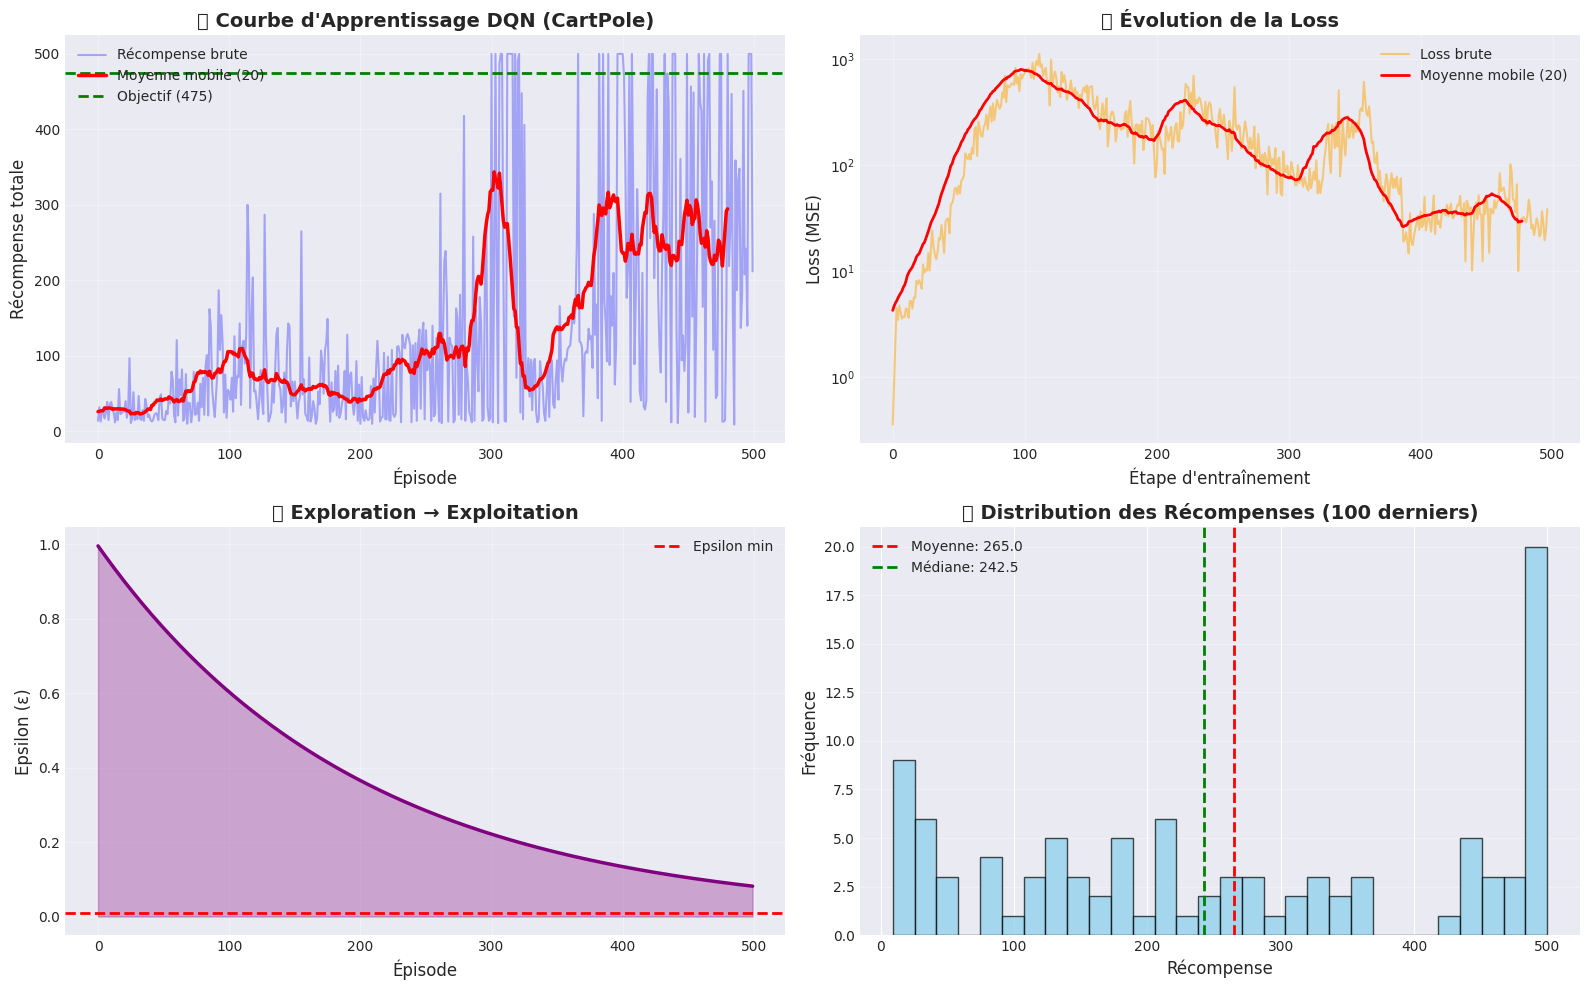


📊 STATISTIQUES FINALES DQN

🏆 Performance (100 derniers épisodes):
   - Récompense moyenne: 265.01
   - Récompense médiane: 242.50
   - Récompense max: 500.00
   - Récompense min: 9.00
   - Écart-type: 174.03

✅ Taux de réussite (≥475 pts): 20.0%

🎯 Exploration:
   - Epsilon final: 0.0816
   - Taille du buffer: 10000

📉 Loss:
   - Loss moyenne (100 derniers): 36.806131
   - Loss finale: 38.413939



In [11]:
# Visualisation complète
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Courbe d'apprentissage DQN
axes[0, 0].plot(rewards_dqn, alpha=0.3, label='Récompense brute', color='blue')
axes[0, 0].plot(moving_average(rewards_dqn, 20), linewidth=2.5, 
                label='Moyenne mobile (20)', color='red')
axes[0, 0].axhline(y=475, color='green', linestyle='--', 
                   label='Objectif (475)', linewidth=2)
axes[0, 0].set_xlabel('Épisode', fontsize=12)
axes[0, 0].set_ylabel('Récompense totale', fontsize=12)
axes[0, 0].set_title('📈 Courbe d\'Apprentissage DQN (CartPole)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss au fil du temps
valid_losses = [l for l in losses_dqn if l > 0]
axes[0, 1].plot(valid_losses, color='orange', alpha=0.5, label='Loss brute')
if len(valid_losses) > 20:
    axes[0, 1].plot(moving_average(valid_losses, 20), linewidth=2, 
                    label='Moyenne mobile (20)', color='red')
axes[0, 1].set_xlabel('Étape d\'entraînement', fontsize=12)
axes[0, 1].set_ylabel('Loss (MSE)', fontsize=12)
axes[0, 1].set_title('📉 Évolution de la Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# 3. Décroissance Epsilon
axes[1, 0].plot(epsilon_dqn, color='purple', linewidth=2.5)
axes[1, 0].fill_between(range(len(epsilon_dqn)), epsilon_dqn, alpha=0.3, color='purple')
axes[1, 0].set_xlabel('Épisode', fontsize=12)
axes[1, 0].set_ylabel('Epsilon (ε)', fontsize=12)
axes[1, 0].set_title('🎯 Exploration → Exploitation', fontsize=14, fontweight='bold')
axes[1, 0].axhline(y=0.01, color='red', linestyle='--', label='Epsilon min', linewidth=2)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution des récompenses (derniers 100 épisodes)
recent_rewards = rewards_dqn[-100:]
axes[1, 1].hist(recent_rewards, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=np.mean(recent_rewards), color='red', linestyle='--', 
                   linewidth=2, label=f'Moyenne: {np.mean(recent_rewards):.1f}')
axes[1, 1].axvline(x=np.median(recent_rewards), color='green', linestyle='--', 
                   linewidth=2, label=f'Médiane: {np.median(recent_rewards):.1f}')
axes[1, 1].set_xlabel('Récompense', fontsize=12)
axes[1, 1].set_ylabel('Fréquence', fontsize=12)
axes[1, 1].set_title('📊 Distribution des Récompenses (100 derniers)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\n" + "="*60)
print("📊 STATISTIQUES FINALES DQN")
print("="*60)
print(f"\n🏆 Performance (100 derniers épisodes):")
print(f"   - Récompense moyenne: {np.mean(rewards_dqn[-100:]):.2f}")
print(f"   - Récompense médiane: {np.median(rewards_dqn[-100:]):.2f}")
print(f"   - Récompense max: {np.max(rewards_dqn[-100:]):.2f}")
print(f"   - Récompense min: {np.min(rewards_dqn[-100:]):.2f}")
print(f"   - Écart-type: {np.std(rewards_dqn[-100:]):.2f}")

success_rate = sum([1 for r in rewards_dqn[-100:] if r >= 475]) / 100 * 100
print(f"\n✅ Taux de réussite (≥475 pts): {success_rate:.1f}%")

print(f"\n🎯 Exploration:")
print(f"   - Epsilon final: {agent_dqn.epsilon:.4f}")
print(f"   - Taille du buffer: {len(agent_dqn.memory)}")

valid_losses_final = [l for l in losses_dqn[-100:] if l > 0]
if valid_losses_final:
    print(f"\n📉 Loss:")
    print(f"   - Loss moyenne (100 derniers): {np.mean(valid_losses_final):.6f}")
    print(f"   - Loss finale: {losses_dqn[-1]:.6f}")

print("\n" + "="*60)

### 🎮 Test de l'Agent DQN Entraîné

In [12]:
print("🤖 Test de l'agent DQN entraîné (5 épisodes):\n")

test_rewards = []
for test_episode in range(5):
    state = env_cartpole.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    total_reward = 0
    steps = 0
    
    for step in range(500):
        # Mode exploitation pure (epsilon = 0)
        q_values = agent_dqn.model.predict(state.reshape(1, -1), verbose=0)
        action = np.argmax(q_values[0])
        
        result = env_cartpole.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result
        
        total_reward += reward
        steps += 1
        state = next_state
        
        if done:
            break
    
    test_rewards.append(total_reward)
    status = "✅" if total_reward >= 475 else "⚠️"
    print(f"{status} Épisode {test_episode+1}: {steps} timesteps, Récompense: {total_reward:.0f}")

print(f"\n🏆 Récompense moyenne sur les tests: {np.mean(test_rewards):.2f}")
print(f"🎯 Taux de réussite: {sum([1 for r in test_rewards if r >= 475])/5*100:.0f}%")

🤖 Test de l'agent DQN entraîné (5 épisodes):

⚠️ Épisode 1: 129 timesteps, Récompense: 129
⚠️ Épisode 2: 127 timesteps, Récompense: 127
⚠️ Épisode 3: 118 timesteps, Récompense: 118
⚠️ Épisode 4: 121 timesteps, Récompense: 121
⚠️ Épisode 5: 115 timesteps, Récompense: 115

🏆 Récompense moyenne sur les tests: 122.00
🎯 Taux de réussite: 0%


### 🔬 Visualisation des Q-Values

🔍 Analyse des Q-Values dans différents états:

État équilibré:
  État: [0. 0. 0. 0.]
  Q-values: Gauche=215.235, Droite=211.433
  Meilleure action: ← Gauche

Bâton penche à droite:
  État: [0.5 0.  0.1 0. ]
  Q-values: Gauche=192.377, Droite=191.394
  Meilleure action: ← Gauche

Bâton penche à gauche:
  État: [-0.5  0.  -0.1  0. ]
  Q-values: Gauche=226.087, Droite=218.853
  Meilleure action: ← Gauche

Chariot se déplace vite:
  État: [0. 1. 0. 0.]
  Q-values: Gauche=200.323, Droite=193.959
  Meilleure action: ← Gauche



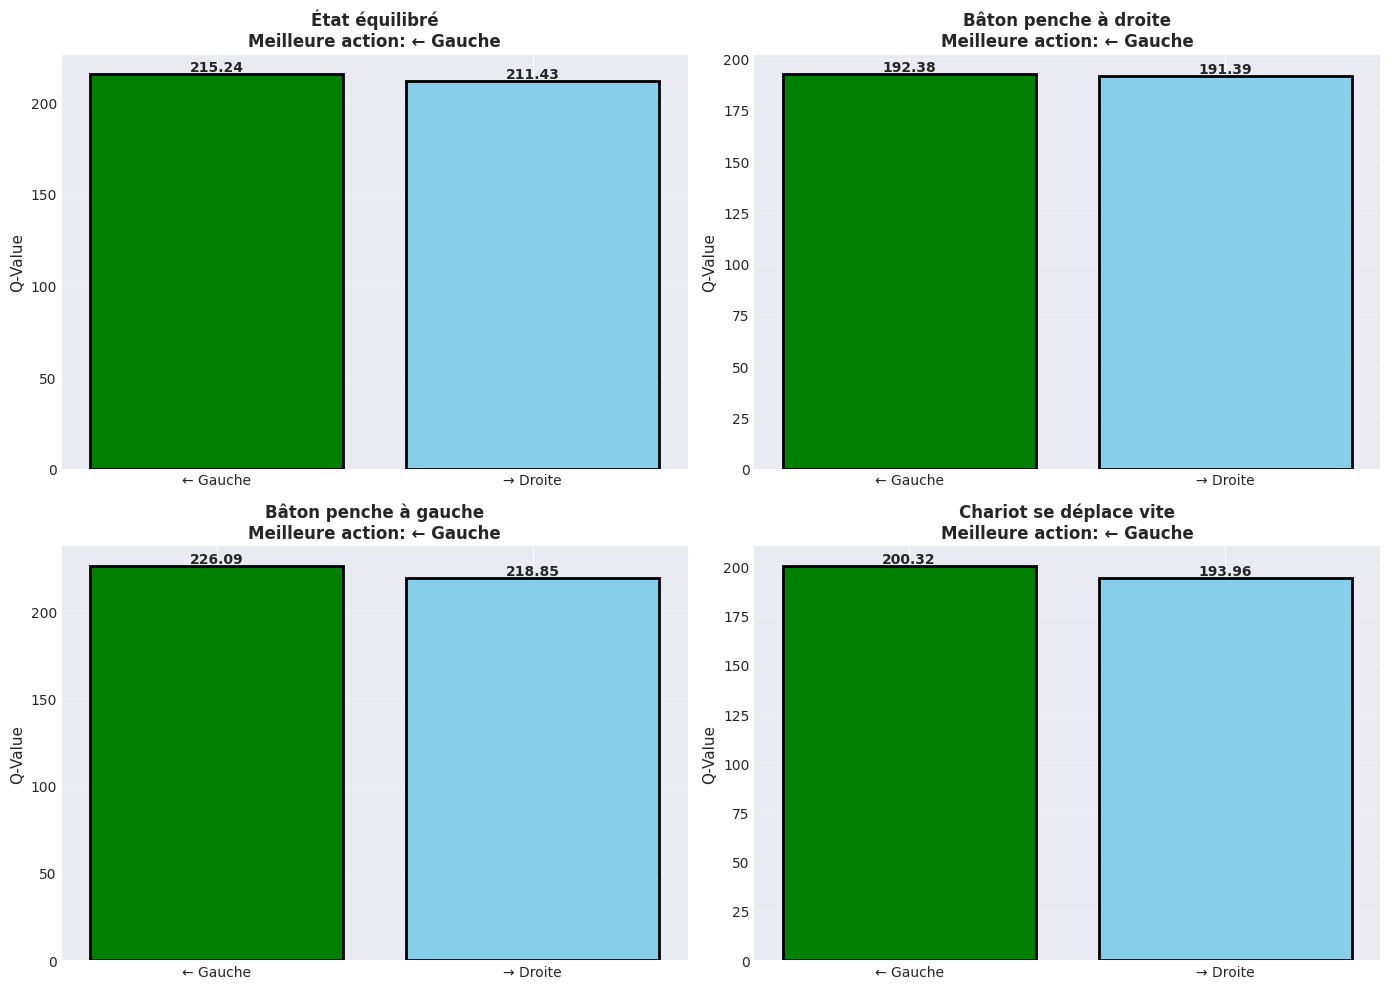

In [13]:
# Analyser les Q-values pour différents états
print("🔍 Analyse des Q-Values dans différents états:\n")

test_states = [
    np.array([0.0, 0.0, 0.0, 0.0]),      # État équilibré
    np.array([0.5, 0.0, 0.1, 0.0]),      # Bâton penche à droite
    np.array([-0.5, 0.0, -0.1, 0.0]),    # Bâton penche à gauche
    np.array([0.0, 1.0, 0.0, 0.0]),      # Chariot se déplace vite
]

state_names = [
    "État équilibré",
    "Bâton penche à droite",
    "Bâton penche à gauche",
    "Chariot se déplace vite"
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (state, name) in enumerate(zip(test_states, state_names)):
    q_values = agent_dqn.model.predict(state.reshape(1, -1), verbose=0)[0]
    best_action = np.argmax(q_values)
    action_names = ['← Gauche', '→ Droite']
    
    colors = ['green' if i == best_action else 'skyblue' for i in range(2)]
    bars = axes[idx].bar(action_names, q_values, color=colors, edgecolor='black', linewidth=2)
    axes[idx].set_ylabel('Q-Value', fontsize=11)
    axes[idx].set_title(f'{name}\nMeilleure action: {action_names[best_action]}', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Afficher valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.2f}',
                      ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    print(f"{name}:")
    print(f"  État: {state}")
    print(f"  Q-values: Gauche={q_values[0]:.3f}, Droite={q_values[1]:.3f}")
    print(f"  Meilleure action: {action_names[best_action]}\n")

plt.tight_layout()
plt.show()

## 8. Comparaison : Q-Learning vs Deep Q-Network

### 📊 Tableau Comparatif

| Critère | Q-Learning (Table) | Deep Q-Network (DQN) |
|---------|-------------------|----------------------|
| **Représentation** | Table discrète | Réseau de neurones |
| **Espace d'états** | Petit et discret uniquement | Continu ou haute dimension |
| **Scalabilité** | ❌ Mauvaise (O(S×A)) | ✅ Excellente |
| **Généralisation** | ❌ Aucune | ✅ Bonne |
| **Mémoire requise** | O(S×A) | O(poids du réseau) |
| **Vitesse d'apprentissage** | ✅ Rapide (petits espaces) | ⚠️  Plus lent au début |
| **Stabilité** | ✅ Stable | ⚠️  Nécessite tricks (replay, target) |
| **Complexité implémentation** | ✅ Simple | ⚠️  Plus complexe |
| **Images/Pixels** | ❌ Impossible | ✅ Possible (CNN) |
| **Garanties théoriques** | ✅ Convergence prouvée | ⚠️  Moins de garanties |

### 🎯 Quand Utiliser Quoi ?

#### Utiliser Q-Learning classique si :
- ✅ Espace d'états **petit et discret** (< 10,000 états)
- ✅ Besoin de **simplicité et rapidité**
- ✅ Problème **pédagogique** ou prototype
- ✅ Garanties théoriques importantes

**Exemples** : GridWorld, Tic-Tac-Toe, petits problèmes de navigation

#### Utiliser DQN (ou Deep RL) si :
- ✅ Espace d'états **continu** ou **haute dimension**
- ✅ États représentés par des **images/pixels**
- ✅ Besoin de **généralisation**
- ✅ Problèmes **complexes du monde réel**

**Exemples** : Jeux Atari, Robotique, Conduite autonome, Trading algorithmique

### 💡 Points Clés à Retenir

1. **DQN est une approximation de fonction de Q-Learning**
   - Remplace la table Q par un réseau de neurones
   - Même principe de Bellman, implémentation différente

2. **Experience Replay est crucial**
   - Casse les corrélations temporelles
   - Réutilise efficacement les données
   - Stabilise grandement l'apprentissage

3. **Target Network stabilise la convergence**
   - Évite les oscillations
   - Cibles plus stables
   - Essentiel pour le succès de DQN

4. **Trade-off complexité vs performance**
   - Q-Learning : simple mais limité
   - DQN : complexe mais puissant
   - Choisir selon le problème

In [14]:
# Visualisation comparative
comparison_html = """
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
            padding: 30px; border-radius: 15px; color: white; margin: 20px 0;">
    <h2 style="text-align: center; margin-bottom: 25px;">🏆 Q-Learning vs DQN : Le Verdict</h2>
    
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
        <div style="background: rgba(255,255,255,0.1); padding: 20px; border-radius: 10px;">
            <h3 style="color: #ffd700; margin-top: 0;">📝 Q-Learning (Table)</h3>
            <p style="font-size: 16px; line-height: 1.6;">
                <strong>Forces:</strong><br>
                ✅ Simplicité d'implémentation<br>
                ✅ Convergence garantie<br>
                ✅ Pas d'hyperparamètres complexes<br>
                ✅ Rapide pour petits espaces<br><br>
                <strong>Faiblesses:</strong><br>
                ❌ Limité aux états discrets<br>
                ❌ Explosion mémoire (S×A)<br>
                ❌ Aucune généralisation<br>
                ❌ Impossible pour images
            </p>
        </div>
        
        <div style="background: rgba(255,255,255,0.1); padding: 20px; border-radius: 10px;">
            <h3 style="color: #00ff88; margin-top: 0;">🧠 Deep Q-Network</h3>
            <p style="font-size: 16px; line-height: 1.6;">
                <strong>Forces:</strong><br>
                ✅ États continus/haute dimension<br>
                ✅ Excellente généralisation<br>
                ✅ Traite les images directement<br>
                ✅ Scale à des millions d'états<br><br>
                <strong>Faiblesses:</strong><br>
                ❌ Complexe à implémenter<br>
                ❌ Instabilité sans tricks<br>
                ❌ Beaucoup d'hyperparamètres<br>
                ❌ Coûteux en calcul
            </p>
        </div>
    </div>
    
    <div style="background: rgba(255,255,255,0.2); padding: 20px; border-radius: 10px; 
                margin-top: 20px; text-align: center;">
        <h3 style="margin-top: 0;">💡 Règle d'Or</h3>
        <p style="font-size: 18px; line-height: 1.8;">
            <strong>"Start simple, scale smart"</strong><br>
            Commencez par Q-Learning pour comprendre les concepts.<br>
            Passez à DQN quand la complexité l'exige.<br>
            Les deux partagent la même philosophie : apprendre Q(s,a) !
        </p>
    </div>
</div>
"""

display(HTML(comparison_html))

## 9. Techniques Avancées en Deep RL

### 🚀 Pour Aller Plus Loin

Maintenant que vous maîtrisez les bases, voici les améliorations modernes du Deep RL :

In [15]:
advanced_techniques_html = """
<div style="background: #f8f9fa; padding: 25px; border-radius: 12px; font-family: Arial, sans-serif;">
    <h2 style="color: #2c3e50; text-align: center; margin-bottom: 25px; font-size: 28px;">
        🚀 Techniques Avancées en Deep Reinforcement Learning
    </h2>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #3498db;">
        <h4 style="color: #3498db;">1. 🎯 Double DQN (DDQN)</h4>
        <p><strong>Problème résolu:</strong> Surestimation des Q-values dans DQN standard</p>
        <p><strong>Innovation:</strong> Découpler sélection et évaluation des actions</p>
        <ul>
            <li><strong>DQN:</strong> max_a' Q_target(s', a') → surestime souvent</li>
            <li><strong>DDQN:</strong> Q_target(s', argmax_a' Q(s', a')) → plus précis</li>
        </ul>
        <p>📈 <em>Amélioration: ~20-30% de performance en plus sur Atari</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #e74c3c;">
        <h4 style="color: #e74c3c;">2. ⚔️ Dueling DQN</h4>
        <p><strong>Problème résolu:</strong> Tous les états n'ont pas besoin de connaître toutes les actions</p>
        <p><strong>Architecture:</strong> Séparer Value et Advantage</p>
        <ul>
            <li><strong>V(s):</strong> Valeur de l'état ("à quel point cet état est bon?")</li>
            <li><strong>A(s,a):</strong> Avantage de l'action ("quelle action est meilleure?")</li>
            <li><strong>Q(s,a) = V(s) + A(s,a)</strong></li>
        </ul>
        <p>🎯 <em>Excellent pour états où actions importent peu (ex: loin de tout danger)</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #9b59b6;">
        <h4 style="color: #9b59b6;">3. 🔮 Prioritized Experience Replay (PER)</h4>
        <p><strong>Problème résolu:</strong> Toutes les expériences ne sont pas également utiles</p>
        <p><strong>Innovation:</strong> Échantillonner plus souvent les transitions surprenantes</p>
        <ul>
            <li>Priorité ∝ |TD-error| = |r + γ max Q(s',a') - Q(s,a)|</li>
            <li>Transitions avec grosse erreur → plus d'apprentissage</li>
            <li>Importance sampling pour corriger le biais</li>
        </ul>
        <p>⚡ <em>Accélération: 2-3x plus rapide sur certains jeux</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #16a085;">
        <h4 style="color: #16a085;">4. 🌈 Rainbow DQN</h4>
        <p><strong>Concept:</strong> Combiner TOUTES les meilleures techniques!</p>
        <ul>
            <li>✅ Double DQN</li>
            <li>✅ Dueling Architecture</li>
            <li>✅ Prioritized Replay</li>
            <li>✅ Multi-step Returns (n-step)</li>
            <li>✅ Distributional RL (C51)</li>
            <li>✅ Noisy Networks</li>
        </ul>
        <p>🏆 <em>State-of-the-art sur Atari benchmark (2017-2020)</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #f39c12;">
        <h4 style="color: #f39c12;">5. 🎭 Policy Gradient Methods</h4>
        <p><strong>Paradigme différent:</strong> Apprendre directement la politique au lieu de Q</p>
        <p><strong>Algorithmes populaires:</strong></p>
        <ul>
            <li><strong>REINFORCE:</strong> Monte Carlo Policy Gradient (1992)</li>
            <li><strong>A2C/A3C:</strong> Advantage Actor-Critic (Asynchrone)</li>
            <li><strong>PPO:</strong> Proximal Policy Optimization (OpenAI, très stable)</li>
            <li><strong>TRPO:</strong> Trust Region Policy Optimization</li>
            <li><strong>SAC:</strong> Soft Actor-Critic (off-policy, très efficace)</li>
        </ul>
        <p>🎯 <em>Meilleur pour actions continues et contrôle robotique</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #e67e22;">
        <h4 style="color: #e67e22;">6. 🔄 Model-Based RL</h4>
        <p><strong>Idée:</strong> Apprendre un modèle de l'environnement</p>
        <ul>
            <li>Prédire (s', r) à partir de (s, a)</li>
            <li>Planifier dans l'imagination avant d'agir</li>
            <li>Sample efficiency ++</li>
            <li><strong>Exemples:</strong> MuZero (DeepMind), DreamerV3</li>
        </ul>
        <p>⚡ <em>10-100x plus efficace en échantillons</em></p>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px; 
                box-shadow: 0 2px 4px rgba(0,0,0,0.1); border-left: 5px solid #27ae60;">
        <h4 style="color: #27ae60;">7. 🏅 Succès Notables du Deep RL</h4>
        <ul style="font-size: 15px;">
            <li>🎮 <strong>AlphaGo/AlphaZero:</strong> Surhumain au Go, Échecs, Shogi</li>
            <li>🎮 <strong>OpenAI Five:</strong> Champion Dota 2</li>
            <li>🎮 <strong>AlphaStar:</strong> GrandMaster StarCraft II</li>
            <li>🧬 <strong>AlphaFold:</strong> Prédiction structure protéines (Nobel 2024!)</li>
            <li>🤖 <strong>Robotique:</strong> Dextérité manipulation d'objets</li>
            <li>💹 <strong>Trading:</strong> Stratégies algorithmiques</li>
            <li>🚗 <strong>Conduite Autonome:</strong> Navigation et décision</li>
            <li>⚡ <strong>Fusion Nucléaire:</strong> Contrôle plasma (DeepMind + EPFL)</li>
        </ul>
    </div>
    
    <div style="background: #e8f5e9; padding: 20px; margin: 15px 0; border-radius: 8px; 
                border-left: 5px solid #2ecc71;">
        <h4 style="color: #2e7d32; margin-top: 0;">🎓 Ressources pour Apprendre</h4>
        <ul>
            <li>📄 <strong>Livres:</strong> Sutton & Barto "RL: An Introduction" (gratuit en ligne)</li>
            <li>📚 <strong>Cours:</strong> David Silver (DeepMind), CS285 Berkeley (Sergey Levine)</li>
            <li>🎥 <strong>Vidéos:</strong> DeepMind Lecture Series, Two Minute Papers</li>
            <li>💻 <strong>Librairies:</strong> Stable-Baselines3, RLlib, CleanRL</li>
            <li>🎮 <strong>Environnements:</strong> OpenAI Gym, DeepMind Control Suite, MuJoCo</li>
            <li>🏆 <strong>Compétitions:</strong> Kaggle RL, NeurIPS competitions</li>
        </ul>
    </div>
    
    <div style="background: #fff3cd; padding: 20px; margin: 15px 0; border-radius: 8px; 
                border-left: 5px solid #ffc107;">
        <h4 style="color: #856404; margin-top: 0;">⚠️ Défis Actuels du Deep RL</h4>
        <ul>
            <li>🐌 <strong>Sample Efficiency:</strong> Millions d'interactions nécessaires</li>
            <li>⚡ <strong>Instabilité:</strong> Hyper-sensible aux hyperparamètres</li>
            <li>🎲 <strong>Reproductibilité:</strong> Résultats varient beaucoup</li>
            <li>💰 <strong>Coût Computationnel:</strong> Nécessite GPUs puissants</li>
            <li>🎯 <strong>Reward Engineering:</strong> Difficile de définir de bonnes récompenses</li>
            <li>🔒 <strong>Sécurité:</strong> Comportements inattendus peuvent être dangereux</li>
        </ul>
    </div>
</div>
"""

display(HTML(advanced_techniques_html))

## 10. Conclusion et Récapitulatif

### 📚 Ce que nous avons appris

#### 1. **Les Fondamentaux du RL**
- Processus de Décision Markoviens (MDP)
- Équation de Bellman
- Exploration vs Exploitation (epsilon-greedy)
- Récompenses et politiques

#### 2. **Q-Learning Classique (Approche Traditionnelle)**
- ✅ Simple et intuitif
- ✅ Garanti de converger (sous conditions)
- ✅ Parfait pour petits espaces discrets
- ❌ Explosion mémoire (S×A)
- ❌ Impossible pour états continus/images
- ❌ Aucune généralisation

#### 3. **Deep Q-Networks (Révolution du Deep RL)**
- ✅ Approximation de fonction avec réseaux de neurones
- ✅ Gère états continus et haute dimension
- ✅ Excellente généralisation
- ✅ Base de nombreux succès (Atari, etc.)
- ❌ Plus complexe à implémenter
- ❌ Instable sans Experience Replay et Target Network

### 🎯 Points Clés à Retenir

1. **RL apprend par essai-erreur** : Pas besoin de supervision, l'agent explore
2. **Trade-off exploration/exploitation** : Epsilon-greedy est simple mais efficace
3. **Experience Replay est magique** : Casse les corrélations, stabilise tout
4. **Target Network est essentiel** : Sans lui, DQN diverge souvent
5. **Deep RL = Q-Learning + Deep Learning** : Même principe, scale différemment
6. **Policy vs Value methods** : Deux paradigmes complémentaires

### 🏆 Comparaison Finale

| Aspect | Q-Learning | DQN | Gagnant |
|--------|------------|-----|----------|
| Simplicité | ✅ Très simple | ❌ Complexe | 🏆 Q-Learning |
| Scalabilité | ❌ Mauvaise | ✅ Excellente | 🏆 DQN |
| États continus | ❌ Non | ✅ Oui | 🏆 DQN |
| Images/Pixels | ❌ Impossible | ✅ Possible | 🏆 DQN |
| Généralisation | ❌ Aucune | ✅ Forte | 🏆 DQN |
| Garanties théoriques | ✅ Fortes | ⚠️ Faibles | 🏆 Q-Learning |
| Vitesse (petit espace) | ✅ Rapide | ⚠️ Plus lent | 🏆 Q-Learning |
| Monde réel | ❌ Limité | ✅ Applicable | 🏆 DQN |

### 🚀 Applications Réelles du Deep RL

- **🎮 Jeux Vidéo** : AlphaGo, AlphaStar, OpenAI Five, Dota 2
- **🤖 Robotique** : Manipulation d'objets, locomotion, assemblage
- **🚗 Conduite Autonome** : Navigation, décision en temps réel
- **💹 Finance** : Trading algorithmique, gestion de portefeuille
- **⚡ Énergie** : Optimisation réseaux, contrôle fusion nucléaire
- **🧬 Santé** : Personnalisation traitements, planification chimiothérapie
- **📡 Télécommunications** : Routage réseau, allocation ressources
- **🏭 Industrie** : Optimisation processus, maintenance prédictive

### 💡 Message Final

L'Apprentissage par Renforcement représente un changement de paradigme fondamental en IA :
- **Apprendre par interaction** plutôt que par supervision
- **Optimiser à long terme** plutôt qu'à court terme
- **S'adapter dynamiquement** à des environnements changeants
- **Découvrir des stratégies** que les humains n'auraient pas imaginées

Le Deep RL combine la puissance du Deep Learning (représentation) avec le RL (décision séquentielle), créant des agents capables de performances surhumaines dans des domaines complexes.

**Le futur est aux agents intelligents qui apprennent en continu !** 🌟

**Félicitations d'avoir complété ce notebook ! Vous comprenez maintenant les fondements du Deep Reinforcement Learning ! 🎉**

## 11. Exercices Pratiques (Bonus)

Pour approfondir votre compréhension du Deep RL :

### Exercice 1 : Expérimentations sur DQN
- Modifiez la taille des couches du réseau (64, 128, 256, 512)
- Ajoutez une couche supplémentaire
- Changez la fonction d'activation (tanh, LeakyReLU)
- Observez l'impact sur la vitesse d'apprentissage

### Exercice 2 : Hyperparamètres
- Variez le learning rate (0.0001, 0.001, 0.01)
- Testez différentes tailles de batch (32, 64, 128, 256)
- Changez la fréquence de mise à jour du target network (5, 10, 20, 50)
- Expérimentez avec gamma (0.9, 0.95, 0.99, 0.999)

### Exercice 3 : Autres Environnements
- Appliquez DQN à **MountainCar-v0** (plus difficile)
- Essayez **Acrobot-v1** (contrôle du double pendule)
- Testez **LunarLander-v2** (atterrissage lunaire)
- Comparez les performances

### Exercice 4 : Double DQN
- Implémentez Double DQN (DDQN)
- Comparez avec DQN standard
- Analysez si la surestimation est réduite
- Mesurez l'amélioration de performance

### Exercice 5 : Dueling Architecture
- Implémentez l'architecture Dueling
- Séparez Value et Advantage streams
- Combinez : Q(s,a) = V(s) + [A(s,a) - mean(A(s,:))]
- Comparez avec DQN standard

### Exercice 6 : Visualisation Avancée
- Enregistrez des vidéos de l'agent en action
- Créez un dashboard en temps réel de l'apprentissage
- Visualisez l'évolution des Q-values pendant l'entraînement
- Analysez les trajectoires de l'agent

### Exercice 7 : Policy Gradient
- Implémentez REINFORCE (Monte Carlo Policy Gradient)
- Comparez avec DQN sur CartPole
- Testez sur un environnement à action continue (Pendulum-v1)
- Analysez les différences de comportement

### Exercice 8 : Amélioration de GridWorld
- Ajoutez des récompenses intermédiaires
- Créez des environnements avec plusieurs objectifs
- Implémentez un environnement avec ennemis mobiles
- Utilisez DQN au lieu de Q-Learning sur GridWorld

### Exercice 9 : Transfer Learning en RL
- Entraînez sur CartPole-v0
- Transférez les poids à CartPole-v1
- Fine-tunez et comparez avec entraînement from scratch
- Explorez le transfer entre environnements similaires

### Exercice 10 : Projet Final
- Créez votre propre environnement personnalisé
- Implémentez un algorithme Deep RL de votre choix
- Documentez vos expérimentations
- Partagez vos résultats et visualisations

### 📚 Ressources Supplémentaires

**Livres :**
- Sutton & Barto - "Reinforcement Learning: An Introduction" (gratuit)
- Maxim Lapan - "Deep Reinforcement Learning Hands-On"

**Cours en ligne :**
- David Silver's RL Course (DeepMind)
- CS285 Deep RL (Berkeley - Sergey Levine)
- Spinning Up in Deep RL (OpenAI)

**Implémentations :**
- Stable-Baselines3 (PyTorch, très bien documentée)
- RLlib (Ray, pour le parallélisme)
- CleanRL (implémentations simples et claires)

**Papers Importants :**
- DQN (Mnih et al., 2015)
- Double DQN (van Hasselt et al., 2015)
- Dueling DQN (Wang et al., 2016)
- Rainbow (Hessel et al., 2017)
- PPO (Schulman et al., 2017)